## Recurrent neural networks (RNNs) 
have become extremely popular in the deep learning space which makes learning them even more imperative. A few real-world applications of RNN include:

* Speech recognition
* Machine translation
* Music composition
* Handwriting recognition
* Grammar learning

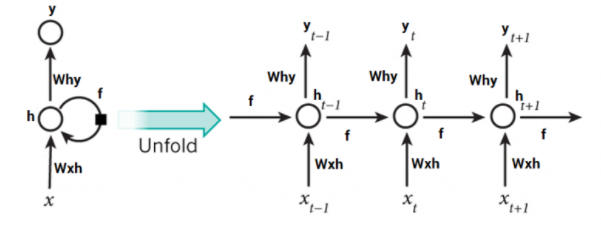

## Task
We will formulate our problem like this – given a sequence of 50 numbers belonging to a sine wave, predict the 51st number in the series.


## Step 0: Data Preparation

In [1]:
%pylab inline

import math

Populating the interactive namespace from numpy and matplotlib


In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])   #200 length array from 0-199

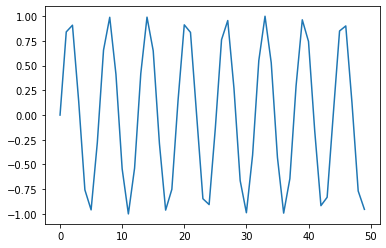

In [3]:
plt.plot(sin_wave[:50])

So the shape of the input data will be:

(number_of_records x length_of_sequence x types_of_sequences)


In [4]:
seq_len=50
num_records=len(sin_wave)-seq_len

In [5]:
len(sin_wave)-seq_len

150

## Training Data Creation

In [6]:
X=[]
Y=[]
for i in range(num_records - 50): # Note that we looped for (num_records – 50) because we want to
                                     # set aside 50 records as our validation data.
    #print(i, i+seq_len)
    X.append(sin_wave[i:i+seq_len])  # appends 100 arrays of 50 length each
    Y.append(sin_wave[i+seq_len])    # extracts all the 51th values from sin function

X=np.array(X)                        # converts the list of arrays into an array format
X=np.expand_dims(X,axis=2)           # converst 100,50 array shape into 3D array 100,50,1 shape

Y=np.array(Y)                        # creates array (100,)
Y=np.expand_dims(Y, axis=1)         # converts to 2D array (100,1)

print(shape(X),shape(Y))


(100, 50, 1) (100, 1)


## validation data

In [7]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

print(shape(X_val),shape(Y_val))

(50, 50, 1) (50, 1)


## Step 1: Create the Architecture for our RNN model

In [8]:
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         # hidden layer dimmension 
output_dim = 1           # output layer

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

### Weights

* U is the weight matrix for weights between input and hidden layers
* V is the weight matrix for weights between hidden and output layers
* W is the weight matrix for shared weights in the RNN layer (hidden layer)

In [9]:
# rnadom initialization of weights

U = np.random.uniform(0, 1, (hidden_dim, T))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
print(U.shape, V.shape, W.shape)

(100, 50) (1, 100) (100, 100)


### Activation function

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Step 2: Train the Model
We can subdivide the training process into smaller steps, namely:

* Step 2.1 : Check the loss on training data
* Step 2.1.1 : Forward Pass
* Step 2.1.2 : Calculate Error
* Step 2.2 : Check the loss on validation data
* Step 2.2.1 : Forward Pass
* Step 2.2.2 : Calculate Error
* Step 2.3 : Start actual training
* Step 2.3.1 : Forward Pass
* Step 2.3.2 : Backpropagate Error
* Step 2.3.3 : Update weights

## Step 2.1: Check the loss on training data
We will do a forward pass through our RNN model and calculate the squared error for the predictions for all records in order to get the loss value.

In [11]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
    #for i in range(3):
        x, y = X[i], Y[i]                    # x gets 50 values, y gets the one value, the 51th 
                                             # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer;
                                             # which is initialized as all zeroes.  shape(100,1)
        
        #print('i=',i,  x.shape, y.shape, prev_s.shape)
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            #print('t=',t,new_input.shape)
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            #print(new_input.shape)
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            #print(s)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error
        #print(prev_s.shape)
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    
    
    
# Step 2.2: Check the loss on validation data

    # check loss on val
    val_loss = 0.0
    for i2 in range(Y_val.shape[0]):
        x, y = X_val[i2], Y_val[i2]
        prev_s = np.zeros((hidden_dim, 1))
        for t2 in range(T):
            new_input = np.zeros(x.shape)
            new_input[t2] = x[t2]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', Val Loss: ', val_loss)    


# step 2.3: Start actual training

# We will now start with the actual training of the network. In this, we will first do a forward pass 
# to calculate the errors and a backward pass to calculate the gradients and update them

## Step 2.3.1: Forward Pass
# In the forward pass:

#* We first multiply the input with the weights between input and hidden layers
#* Add this with the multiplication of weights in the RNN layer. This is because we want to capture the knowledge of the previous timestep
#* pass it through a sigmoid activation function
#* Multiply this with the weights between hidden and output layers
#* At the output layer, we have a linear activation of the values so we do not explicitly pass the value through an activation layer
#* Save the state at the current layer and also the state at the previous timestep in a dictionary

    # train model
    for i3 in range(Y.shape[0]):
        x, y = X[i3], Y[i3]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t3 in range(T):
            new_input = np.zeros(x.shape)
            new_input[t3] = x[t3]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
            
## Step 2.3.2 : BACKPROPAGATE ERROR

# After the forward propagation step, we calculate the gradients at each layer, and backpropagate the errors. 
# We will use truncated back propagation through time (TBPTT), instead of vanilla backprop. 
# It may sound complex but its actually pretty straight forward.

# The core difference in BPTT versus backprop is that the backpropagation step is done for all the time steps in the RNN layer. 
# So if our sequence length is 50, we will backpropagate for all the timesteps previous to the current timestep.

# If you have guessed correctly, BPTT seems very computationally expensive. 
# So instead of backpropagating through all previous timestep , we backpropagate till x timesteps to save computational power. 
# Consider this ideologically similar to stochastic gradient descent, where we include a batch of data points
# instead of all the data points

        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t4 in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t4]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i4 in range(t4-1, max(-1, t4-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t4]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t4] = x[t4]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
## Step 2.3.3 : Update weights

# Lastly, we update the weights with the gradients of weights calculated. 
# One thing we have to keep in mind that the gradients tend to explode if you don’t keep them in check.
# This is a fundamental issue in training neural networks, called the exploding gradient problem. 
# So we have to clamp them in a range so that they dont explode.

            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Loss:  [[108192.22483887]] , Val Loss:  [[54094.27856441]]
Epoch:  2 , Loss:  [[66680.44205377]] , Val Loss:  [[33338.77294592]]
Epoch:  3 , Loss:  [[35168.6592683]] , Val Loss:  [[17583.26732725]]
Epoch:  4 , Loss:  [[13656.87242465]] , Val Loss:  [[6827.75967871]]
Epoch:  5 , Loss:  [[2119.79089225]] , Val Loss:  [[1059.60099929]]
Epoch:  6 , Loss:  [[16.69531071]] , Val Loss:  [[8.30234777]]
Epoch:  7 , Loss:  [[27.65711613]] , Val Loss:  [[13.75597295]]
Epoch:  8 , Loss:  [[26.79088949]] , Val Loss:  [[13.33871768]]
Epoch:  9 , Loss:  [[27.31254137]] , Val Loss:  [[13.59042648]]
Epoch:  10 , Loss:  [[27.53119288]] , Val Loss:  [[13.69983931]]
Epoch:  11 , Loss:  [[27.02515561]] , Val Loss:  [[13.45412006]]
Epoch:  12 , Loss:  [[26.866706]] , Val Loss:  [[13.3711048]]
Epoch:  13 , Loss:  [[26.86330325]] , Val Loss:  [[13.3673222]]
Epoch:  14 , Loss:  [[27.2615819]] , Val Loss:  [[13.56409249]]
Epoch:  15 , Loss:  [[27.03727418]] , Val Loss:  [[13.45597488]]
Epoch:  16 , 

## Step 3: Get predictions

In [12]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

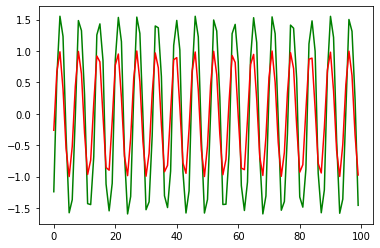

In [13]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

### Checking for overfitting

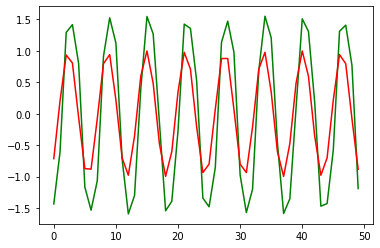

In [14]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] , preds[:, 0, 0] ))

0.6354640394610448

In [24]:
print(Y_val.shape)
Y_val[:,0]

(50, 1)


array([-0.71487643,  0.20214988,  0.93332052,  0.80640058, -0.06192034,
       -0.87331198, -0.88178462, -0.07954854,  0.7958241 ,  0.93951973,
        0.21942526, -0.70240779, -0.97845035, -0.35491018,  0.59493278,
        0.99779728,  0.48329156, -0.47555019, -0.99717329, -0.60199987,
        0.34664946,  0.97659087,  0.70865914, -0.21081053, -0.93646197,
       -0.8011346 ,  0.07075224,  0.87758979,  0.87757534,  0.07072217,
       -0.80115264, -0.9364514 , -0.21078107,  0.70868041,  0.97658438,
        0.34662118, -0.60202394, -0.99717102, -0.47552367,  0.48331795,
        0.99779928,  0.59490855, -0.35493836, -0.97845657, -0.70238633,
        0.21945467,  0.93953006,  0.79580584, -0.07957859, -0.88179884])

In [25]:
print(preds.shape)
preds[:, 0, 0]

(50, 1, 1)


array([-1.43455172, -0.61150739,  1.29330012,  1.41569236,  0.79741539,
       -1.16741855, -1.53415585, -1.06697878,  0.91498381,  1.52459206,
        1.12221245, -0.7196971 , -1.59371083, -1.30042758,  0.38511128,
        1.54565998,  1.26842819, -0.13093106, -1.54369846, -1.39316394,
       -0.27217559,  1.42447209,  1.35561641,  0.52312223, -1.34294091,
       -1.48016451, -0.8570012 ,  1.13668171,  1.47200225,  0.97733828,
       -0.97516509, -1.57225074, -1.20011457,  0.68434826,  1.54985279,
        1.20742025, -0.4616698 , -1.58687067, -1.35343217,  0.08793165,
        1.50834984,  1.30759686,  0.18368821, -1.47020423, -1.42909912,
       -0.57445503,  1.31128331,  1.40815911,  0.76916186, -1.19050947])